In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane

Introduction to Geometric Quantum Machine Learning
==================================================

::: {.meta}
:property=\"og:description\": Using the natural symmetries in a quantum
learning problem can improve learning :property=\"og:image\":
<https://pennylane.ai/qml/_images/equivariant_thumbnail.jpeg>
:::

::: {.related}
tutorial\_equivariant\_graph\_embedding A permutation equivariant graph
embedding
:::

*Author: Richard East --- Posted: 18 October 2022.*

Introduction
------------

Symmetries are at the heart of physics. Indeed in condensed matter and
particle physics we often define a thing simply by the symmetries it
adheres to. What does symmetry mean for those in machine learning? In
this context the ambition is straightforward --- it is a means to reduce
the parameter space and improve the trained model\'s ability to
sucessfully label unseen data, i.e., its ability to generalise.

Suppose we have a learning task and the data we are learning from has an
underlying symmetry. For example, consider a game of Noughts and Crosses
(aka Tic-tac-toe): if we win a game, we would have won it if the board
was rotated or flipped along any of the lines of symmetry. Now if we
want to train an algorithm to spot the outcome of these games, we can
either ignore the existence of this symmetry or we can somehow include
it. The advantage of paying attention to the symmetry is it identifies
multiple configurations of the board as \'the same thing\' as far as the
symmetry is concerned. This means we can reduce our parameter space, and
so the amount of data our algorithm must sift through is immediately
reduced. Along the way, the fact that our learning model must encode a
symmetry that actually exists in the system we are trying to represent
naturally encourages our results to be more generalisable. The encoding
of symmetries into our learning models is where the term *equivariance*
will appear. We will see that demanding that certain symmetries are
included in our models means that the mappings that make up our
algorithms must be such that we could transform our input data with
respect to a certain symmetry, then apply our mappings, and this would
be the same as applying the mappings and then transforming the output
data with the same symmetry. This is the technical property that gives
us the name \"equavariant learning\".

In classical machine learning, this area is often referred to as
geometric deep learning (GDL) due to the traditional association of
symmetry to the world of geometry, and the fact that these
considerations usually focus on deep neural networks (see or for a broad
introduction). We will refer to the quantum computing version of this as
*quantum geometric machine learning* (QGML).

Representation theory in circuits
---------------------------------

The first thing to discuss is how do we work with symmetries in the
first place? The answer lies in the world of group representation
theory.

First, let\'s define what we mean by a group:

**Definition**: A group is a set $G$ together with a binary operation on
$G$, here denoted $\circ$, that combines any two elements $a$ and $b$ to
form an element of $G$, denoted $a \circ b$, such that the following
three requirements, known as group axioms, are satisfied as follows:

1.  **Associativity**: For all $a, b, c$ in $G$, one has
    $(a \circ b) \circ c=a \circ (b \circ c)$.

2.  

    **Identity element**: There exists an element $e$ in $G$ such that, for every $a$ in $G$, one

    :   has $e \circ a=a$ and $a \circ e=a$. Such an element is unique.
        It is called the identity element of the group.

3.  

    **Inverse element**: For each $a$ in $G$, there exists an element $b$ in $G$

    :   such that $a \circ b=e$ and $b \circ a=e$, where $e$ is the
        identity element. For each $a$, the element $b$ is unique: it is
        called the inverse of $a$ and is commonly denoted $a^{-1}$.

With groups defined, we are in a position to articulate what a
representation is: Let $\varphi$ be a map sending $g$ in group $G$ to a
linear map $\varphi(g): V \rightarrow V$, for some vector space $V$,
which satisfies

$$\varphi\left(g_{1} g_{2}\right)=\varphi\left(g_{1}\right) \circ \varphi\left(g_{2}\right) \quad \text { for all } g_{1}, g_{2} \in G.$$

The idea here is that just as elements in a group act on each other to
reach further elements, i.e., $g\circ h = k$, a representation sends us
to a mapping acting on a vector space such that
$\varphi(g)\circ \varphi(h) = \varphi(k)$. In this way we are
representing the structure of the group as a linear map. For a
representation, our mapping must send us to the general linear group
$GL(n)$ (the space of invertible $n \times n$ matrices with matrix
multiplication as the group multiplication). Note how this is both a
group, and by virtue of being a collection of invertible matrices, also
a set of linear maps (they\'re all invertble matrices that can act on
row vectors). Fundamentally, representation theory is based on the
prosaic observation that linear algebra is easy and group theory is
abstract. So what if we can study groups via linear maps?

Now due to the importance of unitarity in quantum mechnics, we are
particularly interested in the unitary representations: representations
where the linear maps are unitary matrices. If we can identify these
then we will have a way to naturally encode groups in quantum circuits
(which are mostly made up of unitary gates).

![](../demonstrations/geometric_qml/sphere_equivariant.png){.align-center
width="45.0%"}

How does all this relate to symmetries? Well, a large class of
symmetries can be characterised as a group, where all the elements of
the group leave some space we are considering unchanged. Let\'s consider
an example: the symmetries of a sphere. Now when we think of this
symmetry we probably think something along the lines of \"it\'s the same
no matter how we rotate it, or flip it left to right, etc\". There is
this idea of being invariant under some operation. We also have the idea
of being able to undo these actions: if we rotate one way, we can rotate
it back. If we flip the sphere right-to-left we can flip it
left-to-right to get back to where we started (notice too all these
inverses are unique). Trivially we can also do nothing. What exactly are
we describing here? We have elements that correspond to an action on a
sphere that can be inverted and for which there exists an identity. It
is also trivially the case here that if we consider three operations a,
b, c from the set of rotations and reflections of the sphere, that if we
combine two of them together then
$a\circ (b \circ c) = (a\circ b) \circ c$. The operations are
associative. These features turn out to literally define a group!

As we\'ve seen the group in itself is a very abstract creature; this is
why we look to its representations. The group labels what symmetries we
care about, they tell us the mappings that our system is invariant
under, and the unitary representations show us how those symmetries look
on a particular space of unitary matrices. If we want to encode the
structure of the symmeteries in a quantum circuit we must restrict our
gates to being unitary representations of the group.

There remains one question: *what is equivariance?* With our newfound
knowledge of group representation theory we are ready to tackle this.
Let $G$ be our group, and $V$ and $W$, with elements $v$ and $w$
respectively, be vector spaces over some field $F$ with a map $f$
between them. Suppose we have representations
$\varphi: G \rightarrow GL(V)$ and $\psi: G \rightarrow GL(W)$.
Furthermore, let\'s write $\varphi_g$ for the representation of $g$ as a
linear map on $V$ and $\psi_g$ as the same group element represented as
a linear map on $W$ respectively. We call $f$ *equivariant* if

$$f(\varphi_g(v))=\psi_g(f(v)) \quad \text { for all } g\in G.$$

The importance of such a map in machine learning is that if, for
example, our neural network layers are equivariant maps then two inputs
that are related by some intrinsic symmetry (maybe they are reflections)
preserve this information in the outputs.

Consider the following figure for example. What we see is a board with a
cross in a certain square on the left and some numerical encoding of
this on the right, where the 1 is where the X is in the number grid. We
present an equivariant mapping between these two spaces with respect to
a group action that is a rotation or a swap (here a $\pi$ rotation). We
can either apply a group action to the original grid and then map to the
number grid, or we could map to the number grid and then apply the group
action. Equivariance demands that the result of either of these
procedures should be the same.

![](../demonstrations/geometric_qml/equivariant-example.jpg){.align-center
width="80.0%"}

Given the vast amount of input data required to train a neural network
the principle that one can pre-encode known symmetry structures into the
network allows us to learn better and faster. Indeed it is the reason
for the success of convolutional neural networks (CNNs) for image
analysis, where it is known they are equivariant with respect to
translations. They naturally encode the idea that a picture of a dog is
symmetrically related to the same picture slid to the left by n pixels,
and they do this by having neural network layers that are equivariant
maps. With our focus on unitary representations (and so quantum
circuits) we are looking to extend this idea to quantum machine
learning.


Noughts and Crosses
===================

Let\'s look at the game of noughts and crosses, as inspired by. Two
players take turns to place a O or an X, depending on which player they
are, in a 3x3 grid. The aim is to get three of your symbols in a row,
column, or diagonal. As this is not always possible depending on the
choices of the players, there could be a draw. Our learning task is to
take a set of completed games labelled with their outcomes and teach the
algorithm to identify these correctly.


This board of nine elements has the symmetry of the square, also known
as the *dihedral group*. This means it is symmetric under
$\frac{\pi}{2}$ rotations and flips about the lines of symmetry of a
square (vertical, horizontal, and both diagonals).


![](../demonstrations/geometric_qml/NandC_sym.png){.align-center
width="70.0%"}


**The question is, how do we encode this in our QML problem?**

First, let us encode this problem classically. We will consider a
nine-element vector $v$, each element of which identifies a square of
the board. The entries themselves can be $+1$,$0$,$-1,$ representing a
nought, no symbol, or a cross. The label is one-hot encoded in a vector
$y=(y_O,y_- , y_X)$ with $+1$ in the correct label and $-1$ in the
others. For instance (-1,-1,1) would represent an X in the relevant
position.


To create the quantum model let us take nine qubits and let them
represent squares of our board. We\'ll initialise them all as
$|0\rangle$, which we note leaves the board invariant under the
symmetries of the problem (flip and rotate all you want, it\'s still
going to be zeroes whatever your mapping). We will then look to apply
single qubit $R_x(\theta)$ rotations on individual qubits, encoding each
of the possibilities in the board squares at an angle of
$\frac{2\pi}{3}$ from each other. For our parameterised gates we will
have a single-qubit $R_x(\theta_1)$ and $R_y(\theta_2)$ rotation at each
point. We will then use $CR_y(\theta_3)$ for two-qubit entangling gates.
This implies that, for each encoding, crudely, we\'ll need 18
single-qubit rotation parameters and $\binom{9}{2}=36$ two-qubit gate
rotations. Let\'s see how, by using symmetries, we can reduce this.


![..](../demonstrations/geometric_qml/grid.jpg){.align-center
width="35.0%"}

The indexing of our game board.


The secret will be to encode the symmetries into the gate set so the
observables we are interested in inherently respect the symmetries. How
do we do this? We need to select the collections of gates that commute
with the symmetries. In general, we can use the twirling formula for
this:

::: {.tip}
::: {.title}
Tip
:::

Let $\mathcal{S}$ be the group that encodes our symmetries and $U$ be a
unitary representation of $\mathcal{S}$. Then,

$$\mathcal{T}_{U}[X]=\frac{1}{|\mathcal{S}|} \sum_{s \in \mathcal{S}} U(s) X U(s)^{\dagger}$$

defines a projector onto the set of operators commuting with all
elements of the representation, i.e.,
$\left[\mathcal{T}_{U}[X], U(s)\right]=$ 0 for all $X$ and
$s \in \mathcal{S}$.
:::

The twirling process applied to an arbitrary unitary will give us a new
unitary that commutes with the group as we require. We remember that
unitary gates typically have the form $W = \exp(-i\theta H)$, where $H$
is a Hermitian matrix called a *generator*, and $\theta$ may be fixed or
left as a free parameter. A recipe for creating a unitary that commutes
with our symmetries is to *twirl the generator of the gate*, i.e., we
move from the gate $W = \exp(-i\theta H)$ to the gate
$W' = \exp(-i\theta\mathcal{T}_U[H])$. When each term in the twirling
formula acts on different qubits, then this unitary would further
simplify to

$$W' = \bigotimes_{s\in\mathcal{S}}U(s)\exp(-i\tfrac{\theta}{\vert\mathcal{S}\vert})U(s)^\dagger.$$

For simplicity, we can absorb the normalization factor
$\vert\mathcal{S}\vert$ into the free parameter $\theta$.

So let\'s look again at our choice of gates: single-qubit $R_x(\theta)$
and $R_y(\theta)$ rotations, and entangling two-qubit $CR_y(\phi)$
gates. What will we get by twirling these?


In this particular instance we can see the action of the twirling
operation geometrically as the symmetries involved are all permutations.
Let\'s consider the $R_x$ rotation acting on one qubit. Now if this
qubit is in the centre location on the grid, then we can flip around any
symmetry axis we like, and this operation leaves the qubit invariant, so
we\'ve identified one equivariant gate immediately. If the qubit is on
the corners, then the flipping will send this qubit rotation to each of
the other corners. Similarly, if a qubit is on the central edge then the
rotation gate will be sent round the other edges. So we can see that the
twirling operation is a sum over all the possible outcomes of performing
the symmetry action (the sum over the symmetry group actions). Having
done this we can see that for a single-qubit rotation the invariant maps
are rotations on the central qubit, at all the corners, and at all the
central edges (when their rotation angles are fixed to be the same).

As an example consider the following figure, where we take a $R_x$ gate
in the corner and then apply all the symmetries of a square. The result
of this twirling leads us to have the same gate at all the corners.


![](../demonstrations/geometric_qml/twirl.jpeg){.align-center
width="70.0%"}


For entangling gates the situation is similar. There are three invariant
classes, the centre entangled with all corners, with all edges, and the
edges paired in a ring.


The prediction of a label is obtained via a one-hot-encoding by
measuring the expectation values of three invariant observables:


$$O_{-}=Z_{\text {middle }}=Z_{4}$$

$$O_{\circ}=\frac{1}{4} \sum_{i \in \text { corners }} Z_{i}=\frac{1}{4}\left[Z_{0}+Z_{2}+Z_{6}+Z_{8}\right]$$

$$O_{\times}=\frac{1}{4} \sum_{i \in \text { edges }} Z_{i}=\frac{1}{4}\left[Z_{1}+Z_{3}+Z_{5}+Z_{7}\right]$$

$$\hat{\boldsymbol{y}}=\left(\left\langle O_{\circ}\right\rangle,\left\langle O_{-}\right\rangle,\left\langle O_{\times}\right\rangle\right)$$


This is the quantum encoding of the symmetries into a learning problem.
A prediction for a given data point will be obtained by selecting the
class for which the observed expectation value is the largest.


Now that we have a specific encoding and have decided on our observables
we need to choose a suitable cost function to optimise. We will use an
$l_2$ loss function acting on pairs of games and labels $D={(g,y)}$,
where $D$ is our dataset.


Let\'s now implement this!

First let\'s generate some games. Here we are creating a small program
that will play Noughts and Crosses against itself in a random fashion.
On completion, it spits out the winner and the winning board, with
noughts as +1, draw as 0, and crosses as -1. There are 26,830 different
possible games but we will only sample a few hundred.


In [3]:
import torch
import random

# Fix seeds for reproducability
torch.backends.cudnn.deterministic = True
torch.manual_seed(16)
random.seed(16)

#  create an empty board
def create_board():
    return torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])


# Check for empty places on board
def possibilities(board):
    l = []
    for i in range(len(board)):
        for j in range(3):
            if board[i, j] == 0:
                l.append((i, j))
    return l


# Select a random place for the player
def random_place(board, player):
    selection = possibilities(board)
    current_loc = random.choice(selection)
    board[current_loc] = player
    return board


# Check if there is a winner by having 3 in a row
def row_win(board, player):
    for x in range(3):
        lista = []
        win = True

        for y in range(3):
            lista.append(board[x, y])

            if board[x, y] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 in a column
def col_win(board, player):
    for x in range(3):
        win = True

        for y in range(3):
            if board[y, x] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 along a diagonal
def diag_win(board, player):
    win1 = True
    win2 = True
    for x, y in [(0, 0), (1, 1), (2, 2)]:
        if board[x, y] != player:
            win1 = False

    for x, y in [(0, 2), (1, 1), (2, 0)]:
        if board[x, y] != player:
            win2 = False

    return win1 or win2


# Check if the win conditions have been met or if a draw has occurred
def evaluate_game(board):
    winner = None
    for player in [1, -1]:
        if row_win(board, player) or col_win(board, player) or diag_win(board, player):
            winner = player

    if torch.all(board != 0) and winner == None:
        winner = 0

    return winner


# Main function to start the game
def play_game():
    board, winner, counter = create_board(), None, 1
    while winner == None:
        for player in [1, -1]:
            board = random_place(board, player)
            counter += 1
            winner = evaluate_game(board)
            if winner != None:
                break

    return [board.flatten(), winner]


def create_dataset(size_for_each_winner):
    game_d = {-1: [], 0: [], 1: []}

    while min([len(v) for k, v in game_d.items()]) < size_for_each_winner:
        board, winner = play_game()
        if len(game_d[winner]) < size_for_each_winner:
            game_d[winner].append(board)

    res = []
    for winner, boards in game_d.items():
        res += [(board, winner) for board in boards]

    return res


NUM_TRAINING = 450
NUM_VALIDATION = 600

# Create datasets but with even numbers of each outcome
with torch.no_grad():
    dataset = create_dataset(NUM_TRAINING // 3)
    dataset_val = create_dataset(NUM_VALIDATION // 3)

Now let\'s create the relevant circuit expectation values that respect
the symmetry classes we defined over the single-site and two-site
measurements.


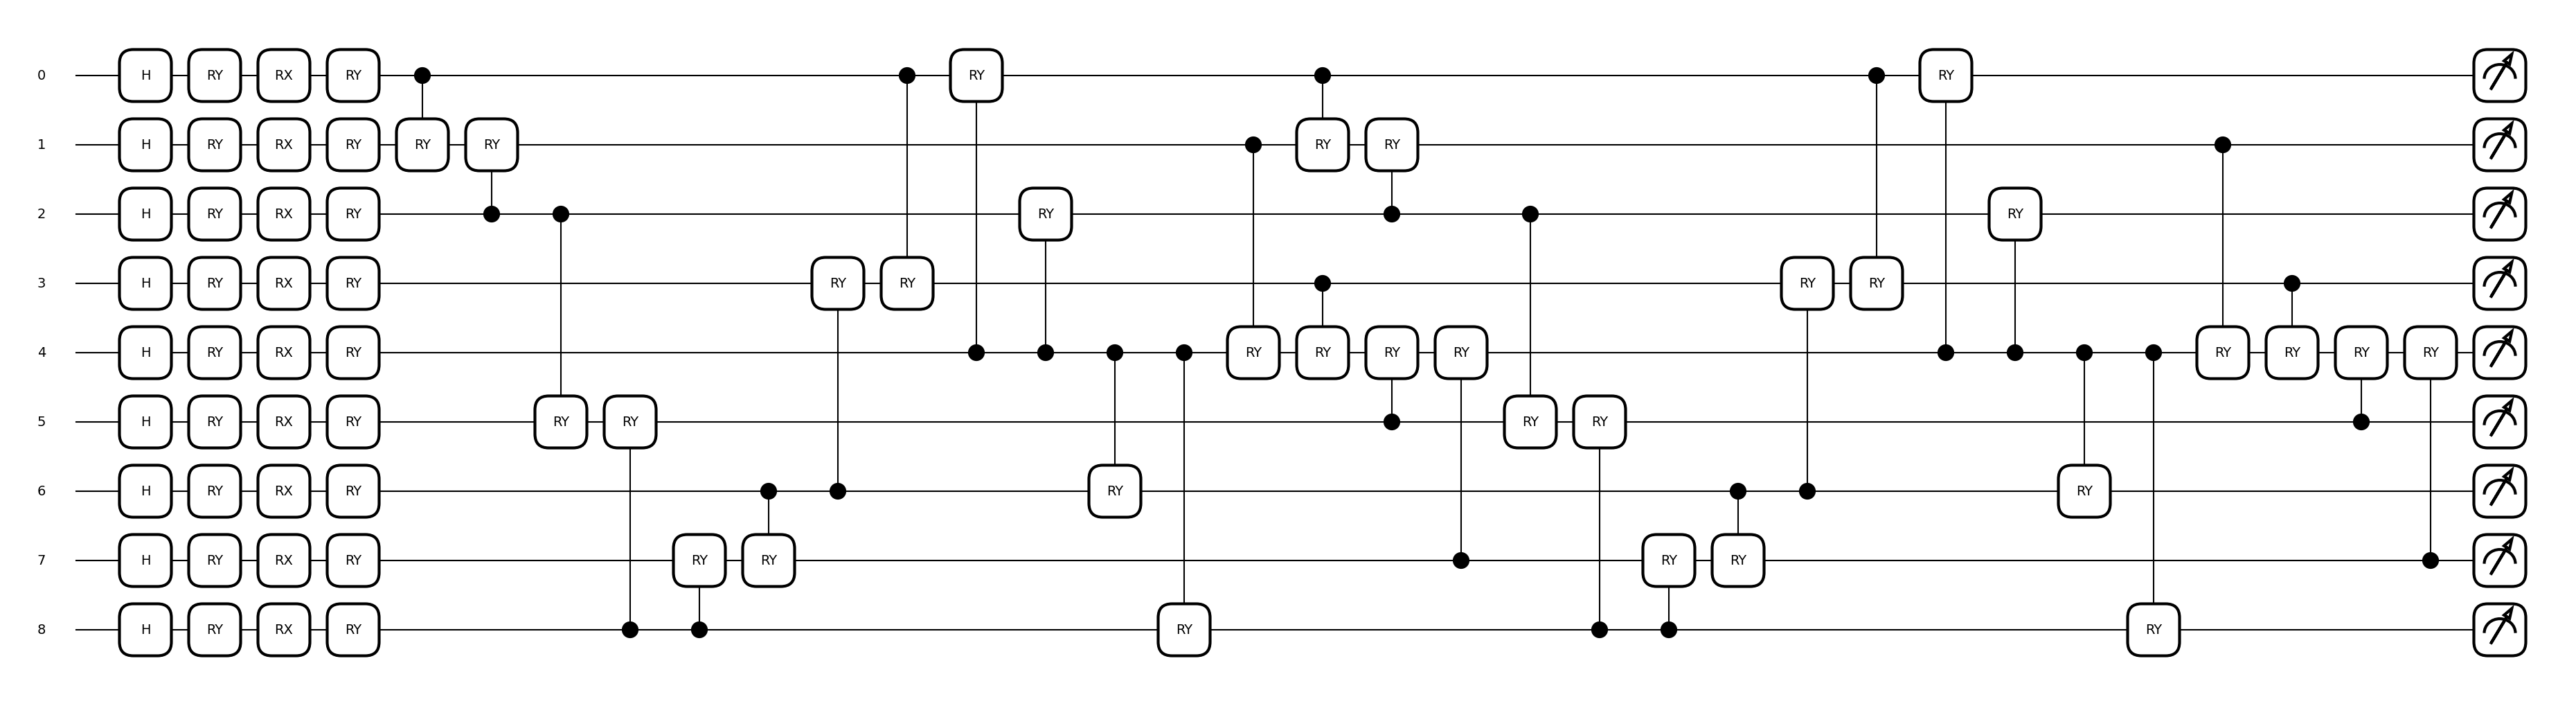

In [4]:
import pennylane as qml
import matplotlib.pyplot as plt

# Set up a nine-qubit system
dev = qml.device("default.qubit.torch", wires=9)

ob_center = qml.PauliZ(4)
ob_corner = (qml.PauliZ(0) + qml.PauliZ(2) + qml.PauliZ(6) + qml.PauliZ(8)) * (1 / 4)
ob_edge = (qml.PauliZ(1) + qml.PauliZ(3) + qml.PauliZ(5) + qml.PauliZ(7)) * (1 / 4)

# Now let's encode the data in the following qubit models, first with symmetry
@qml.qnode(dev, interface="torch")
def circuit(x, p):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)
    qml.Hadamard(wires=6)
    qml.Hadamard(wires=7)
    qml.Hadamard(wires=8)
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(x[2], wires=2)
    qml.RY(x[3], wires=3)
    qml.RY(x[4], wires=4)
    qml.RY(x[5], wires=5)
    qml.RY(x[6], wires=6)
    qml.RY(x[7], wires=7)
    qml.RY(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[2], wires=2)
    qml.RX(p[2], wires=6)
    qml.RX(p[2], wires=8)

    qml.RY(p[3], wires=0)
    qml.RY(p[3], wires=2)
    qml.RY(p[3], wires=6)
    qml.RY(p[3], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[4], wires=1)
    qml.RX(p[4], wires=3)
    qml.RX(p[4], wires=5)
    qml.RX(p[4], wires=7)

    qml.RY(p[5], wires=1)
    qml.RY(p[5], wires=3)
    qml.RY(p[5], wires=5)
    qml.RY(p[5], wires=7)

    # Double Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[6], wires=[0, 1])
    qml.CRY(p[6], wires=[2, 1])
    qml.CRY(p[6], wires=[2, 5])
    qml.CRY(p[6], wires=[8, 5])
    qml.CRY(p[6], wires=[8, 7])
    qml.CRY(p[6], wires=[6, 7])
    qml.CRY(p[6], wires=[6, 3])
    qml.CRY(p[6], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[7], wires=[4, 0])
    qml.CRY(p[7], wires=[4, 2])
    qml.CRY(p[7], wires=[4, 6])
    qml.CRY(p[7], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[8], wires=[1, 4])
    qml.CRY(p[8], wires=[3, 4])
    qml.CRY(p[8], wires=[5, 4])
    qml.CRY(p[8], wires=[7, 4])

    # circling the edge of the board
    qml.CRY(p[6], wires=[0, 1])
    qml.CRY(p[6], wires=[2, 1])
    qml.CRY(p[6], wires=[2, 5])
    qml.CRY(p[6], wires=[8, 5])
    qml.CRY(p[6], wires=[8, 7])
    qml.CRY(p[6], wires=[6, 7])
    qml.CRY(p[6], wires=[6, 3])
    qml.CRY(p[6], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[7], wires=[4, 0])
    qml.CRY(p[7], wires=[4, 2])
    qml.CRY(p[7], wires=[4, 6])
    qml.CRY(p[7], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[8], wires=[1, 4])
    qml.CRY(p[8], wires=[3, 4])
    qml.CRY(p[8], wires=[5, 4])
    qml.CRY(p[8], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit)([0] * 9, 18 * [0])

Let\'s also look at the same series of gates but this time they are
applied independently from one another, so we won\'t be preserving the
symmetries with our gate operations. Practically this also means more
parameters, as previously groups of gates were updated together.


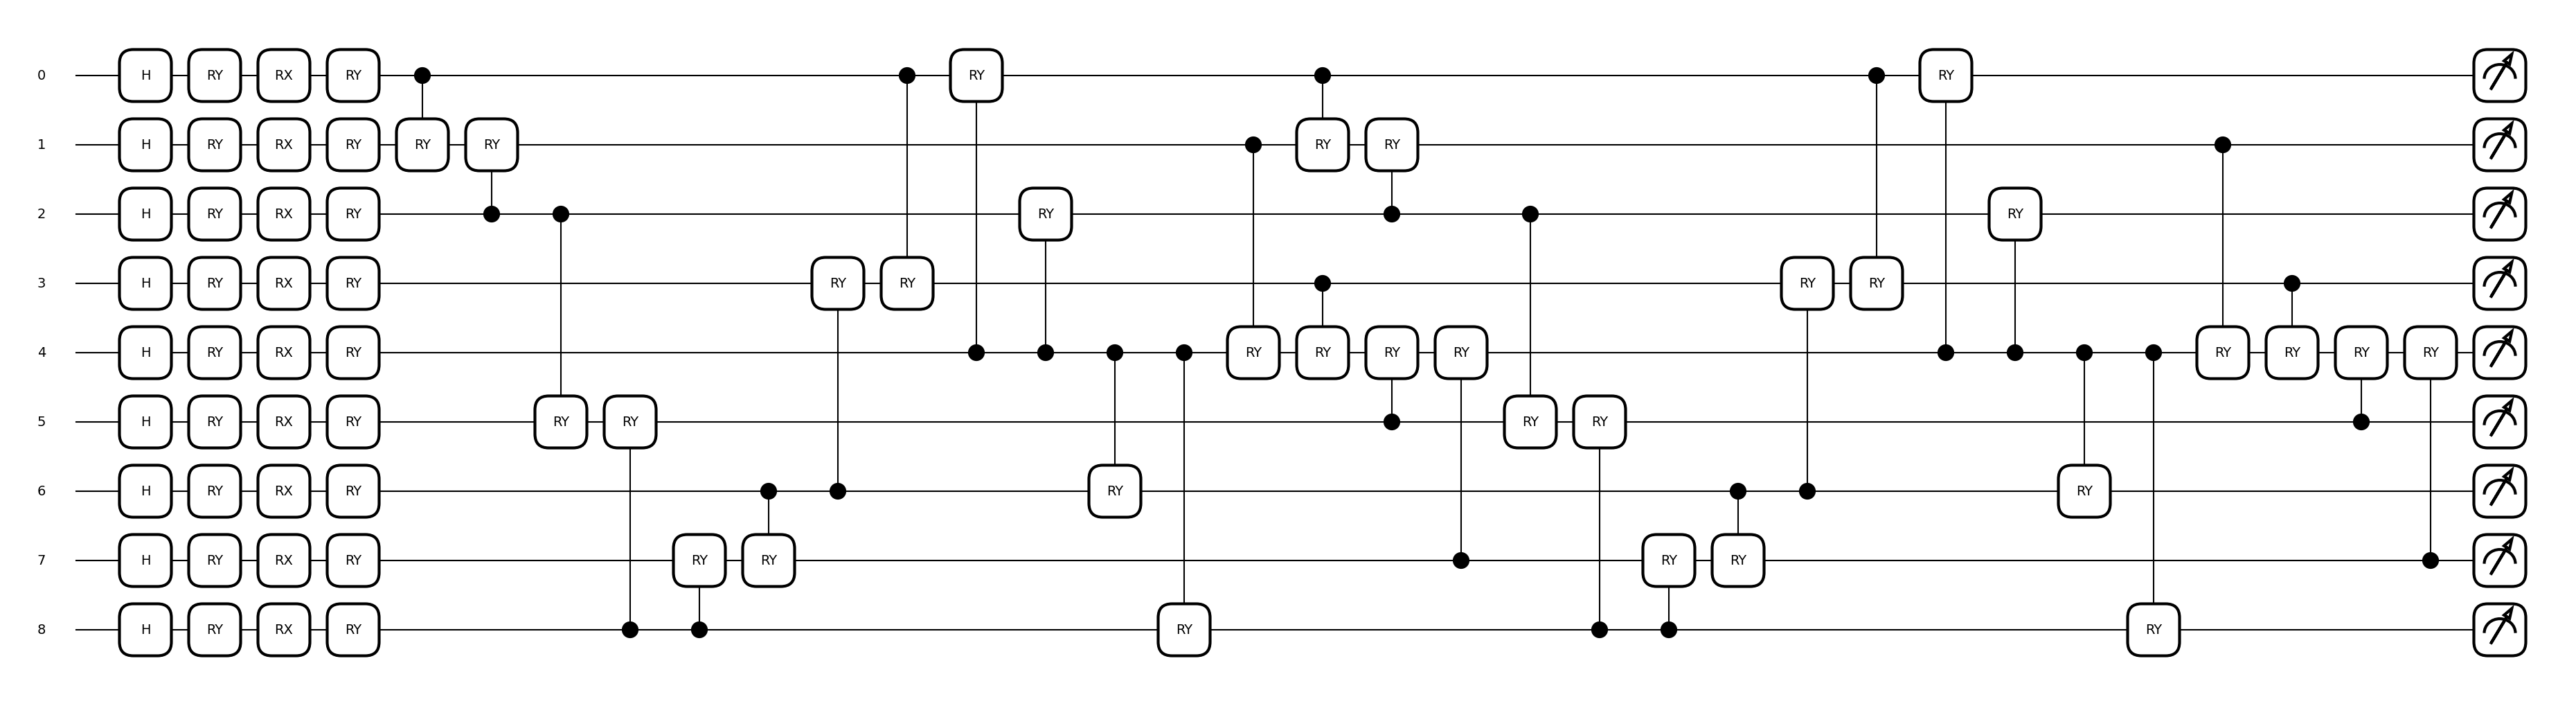

In [5]:
@qml.qnode(dev, interface="torch")
def circuit_no_sym(x, p):

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)
    qml.Hadamard(wires=6)
    qml.Hadamard(wires=7)
    qml.Hadamard(wires=8)
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(x[2], wires=2)
    qml.RY(x[3], wires=3)
    qml.RY(x[4], wires=4)
    qml.RY(x[5], wires=5)
    qml.RY(x[6], wires=6)
    qml.RY(x[7], wires=7)
    qml.RY(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Note in this circuit the parameters aren't all the same.
    # Previously they were identical to ensure they were applied
    # as one combined gate. The fact they can all vary independently
    # here means we aren't respecting the symmetry.

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[3], wires=2)
    qml.RX(p[4], wires=6)
    qml.RX(p[5], wires=8)

    qml.RY(p[6], wires=0)
    qml.RY(p[7], wires=2)
    qml.RY(p[8], wires=6)
    qml.RY(p[9], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[10], wires=1)
    qml.RX(p[11], wires=3)
    qml.RX(p[12], wires=5)
    qml.RX(p[13], wires=7)

    qml.RY(p[14], wires=1)
    qml.RY(p[15], wires=3)
    qml.RY(p[16], wires=5)
    qml.RY(p[17], wires=7)

    # Double Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[18], wires=[0, 1])
    qml.CRY(p[19], wires=[2, 1])
    qml.CRY(p[20], wires=[2, 5])
    qml.CRY(p[21], wires=[8, 5])
    qml.CRY(p[22], wires=[8, 7])
    qml.CRY(p[23], wires=[6, 7])
    qml.CRY(p[24], wires=[6, 3])
    qml.CRY(p[25], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[26], wires=[4, 0])
    qml.CRY(p[27], wires=[4, 2])
    qml.CRY(p[28], wires=[4, 6])
    qml.CRY(p[29], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[30], wires=[1, 4])
    qml.CRY(p[31], wires=[3, 4])
    qml.CRY(p[32], wires=[5, 4])
    qml.CRY(p[33], wires=[7, 4])

    # circling the edge of the board
    qml.CRY(p[18], wires=[0, 1])
    qml.CRY(p[19], wires=[2, 1])
    qml.CRY(p[20], wires=[2, 5])
    qml.CRY(p[21], wires=[8, 5])
    qml.CRY(p[22], wires=[8, 7])
    qml.CRY(p[23], wires=[6, 7])
    qml.CRY(p[24], wires=[6, 3])
    qml.CRY(p[25], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[26], wires=[4, 0])
    qml.CRY(p[27], wires=[4, 2])
    qml.CRY(p[28], wires=[4, 6])
    qml.CRY(p[29], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[30], wires=[1, 4])
    qml.CRY(p[31], wires=[3, 4])
    qml.CRY(p[32], wires=[5, 4])
    qml.CRY(p[33], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit_no_sym)([0] * 9, [0] * 34)

Note again how, though these circuits have a similar form to before,
they are parameterised differently. We need to feed the vector
$\boldsymbol{y}$ made up of the expectation value of these three
operators into the loss function and use this to update our parameters.


In [6]:
import math

def encode_game(game):
    board, res = game
    x = board * (2 * math.pi) / 3
    if res == 1:
        y = [-1, -1, 1]
    elif res == -1:
        y = [1, -1, -1]
    else:
        y = [-1, 1, -1]
    return x, y

Recall that the loss function we\'re interested in is
$\mathcal{L}(\mathcal{D})=\frac{1}{|\mathcal{D}|} \sum_{(\boldsymbol{g}, \boldsymbol{y}) \in \mathcal{D}}\|\hat{\boldsymbol{y}}(\boldsymbol{g})-\boldsymbol{y}\|_{2}^{2}$.
We need to define this and then we can begin our optimisation.


In [7]:
# calculate the mean square error for this classification problem
def cost_function(params, input, target):
    output = torch.stack([torch.hstack(circuit(x, params)) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)

Let\'s now train our symmetry-preserving circuit on the data.


In [8]:
from torch import optim
import numpy as np

params = 0.01 * torch.randn(9)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)


max_epoch = 15
max_step = 30
batch_size = 10

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([torch.hstack(circuit(x, p)) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy(params, *encoded_dataset_val)}")

x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs_sym = []
saved_accs_sym = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs_sym.append(cost)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy(params, *encoded_dataset_val)
        saved_accs_sym.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

accuracy without training = 0.5249999761581421
Epoch:  1 | Loss: 3.176805 | Validation accuracy: 0.485000
Epoch:  2 | Loss: 2.856527 | Validation accuracy: 0.436667
Epoch:  3 | Loss: 2.822027 | Validation accuracy: 0.496667
Epoch:  4 | Loss: 2.764042 | Validation accuracy: 0.456667
Epoch:  5 | Loss: 2.671184 | Validation accuracy: 0.560000
Epoch:  6 | Loss: 2.681827 | Validation accuracy: 0.545000
Epoch:  7 | Loss: 2.649758 | Validation accuracy: 0.541667
Epoch:  8 | Loss: 2.564894 | Validation accuracy: 0.573333
Epoch:  9 | Loss: 2.649880 | Validation accuracy: 0.591667
Epoch: 10 | Loss: 2.615056 | Validation accuracy: 0.580000
Epoch: 11 | Loss: 2.590838 | Validation accuracy: 0.596667
Epoch: 12 | Loss: 2.577285 | Validation accuracy: 0.583333
Epoch: 13 | Loss: 2.638542 | Validation accuracy: 0.581667
Epoch: 14 | Loss: 2.569011 | Validation accuracy: 0.595000
Epoch: 15 | Loss: 2.578797 | Validation accuracy: 0.585000


Now we train the non-symmetry preserving circuit.


In [9]:
params = 0.01 * torch.randn(34)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)

# calculate mean square error for this classification problem


def cost_function_no_sym(params, input, target):
    output = torch.stack([torch.hstack(circuit_no_sym(x, params)) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)


max_epoch = 15
max_step = 30
batch_size = 15

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy_no_sym(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([torch.hstack(circuit_no_sym(x, p)) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy_no_sym(params, *encoded_dataset_val)}")


x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs = []
saved_accs = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function_no_sym(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs.append(costs)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy_no_sym(params, *encoded_dataset_val)
        saved_accs.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

accuracy without training = 0.44999998807907104
Epoch:  1 | Loss: 3.169856 | Validation accuracy: 0.438333
Epoch:  2 | Loss: 2.915814 | Validation accuracy: 0.443333
Epoch:  3 | Loss: 2.848999 | Validation accuracy: 0.445000
Epoch:  4 | Loss: 2.798156 | Validation accuracy: 0.428333
Epoch:  5 | Loss: 2.745969 | Validation accuracy: 0.453333
Epoch:  6 | Loss: 2.714810 | Validation accuracy: 0.461667
Epoch:  7 | Loss: 2.697196 | Validation accuracy: 0.485000
Epoch:  8 | Loss: 2.678972 | Validation accuracy: 0.480000
Epoch:  9 | Loss: 2.667330 | Validation accuracy: 0.510000
Epoch: 10 | Loss: 2.651770 | Validation accuracy: 0.513333
Epoch: 11 | Loss: 2.636838 | Validation accuracy: 0.525000
Epoch: 12 | Loss: 2.623924 | Validation accuracy: 0.560000
Epoch: 13 | Loss: 2.608304 | Validation accuracy: 0.531667
Epoch: 14 | Loss: 2.597640 | Validation accuracy: 0.555000
Epoch: 15 | Loss: 2.588152 | Validation accuracy: 0.565000


Finally let\'s plot the results and see how the two training regimes
differ.


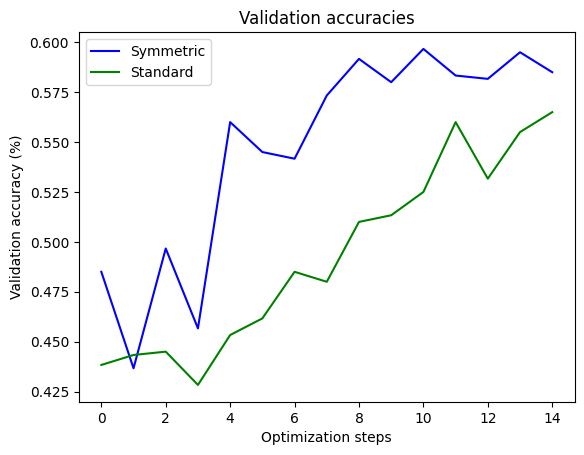

In [10]:
from matplotlib import pyplot as plt

plt.title("Validation accuracies")
plt.plot(saved_accs_sym, "b", label="Symmetric")
plt.plot(saved_accs, "g", label="Standard")

plt.ylabel("Validation accuracy (%)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

What we can see then is that by paying attention to the symmetries
intrinsic to the learning problem and reflecting this in an equivariant
gate set we have managed to improve our learning accuracies, while also
using fewer parameters. While the symmetry-aware circuit clearly
outperforms the naive one, it is notable however that the learning
accuracies in both cases are hardly ideal given this is a solved game.
So paying attention to symmetries definitely helps, but it also isn\'t a
magic bullet!


The use of symmetries in both quantum and classical machine learning is
a developing field, so we can expect new results to emerge over the
coming years. If you want to get involved, the references given below
are a great place to start.


References
==========


Acknowledgments
===============

The author would also like to acknowledge the helpful input of C.-Y.
Park.


About the author
================
